# Example

This is a notebook example of how to implement the different function provided in the github page. The following is the code used to analyze a mock CMD provided by Maritza Lara Lopez, professor at the 'Galaxy Formation and Evolution' course at UCMs Astrophysics Master (and Ramon y Cajal Fellow as of 2023). The results agree extremly well with what was expected, because the mock CMD was also generated with IAC-Star, the program with which the synthetic CMDs will be created. Nevertheless, serves as a good example.

First things first:

#### Import the functiosns and packages to be used

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import smplotlib
import pandas as pd
from scipy.stats import binned_statistic_2d

from data_loader_iacSTAR import LoadData
from bin_determination import getBinNumber
from bundles import BundleMaker
from chi_squared_models import caluclate_chi_squared
from binning import BinTheData

Loading the data. This one is the mock CMD provided by Maritza. The .txt can be read directly with pd.read_csv. For the outputs generated by IAC-Star, this cannot be done directly, that is why data_loader_iacSTAR.py is there.

In [53]:
mock_CMD_Nalto = pd.read_csv('cmd_Nalto.txt', delimiter='\s+', comment='#')
mock_CMD_Nalto['V-I'] = mock_CMD_Nalto['V']-mock_CMD_Nalto['I']
VminusI_Nalto = mock_CMD_Nalto['V-I']
I_Nalto = mock_CMD_Nalto['I']
Teff_Nalto = mock_CMD_Nalto['log(Teff)']
mock_CMD_Nalto

,log(L),log(Teff),log(g),Mbol,U,B,V,R,I,J,H,K,L,L`,M,V-I
0,0.898,3.883,4.230,2.496,2.791,2.719,2.467,2.342,2.190,2.106,2.003,1.973,1.987,1.985,1.856,0.277
1,1.504,3.957,4.052,0.980,1.164,1.125,1.099,1.078,1.028,1.034,1.013,0.995,1.024,1.027,0.988,0.071
2,0.690,3.847,4.247,3.016,3.339,3.358,3.008,2.822,2.633,2.431,2.288,2.257,2.255,2.254,2.087,0.375
3,0.440,3.812,4.301,3.639,4.103,4.123,3.665,3.410,3.164,2.866,2.645,2.606,2.587,2.587,2.341,0.501
4,0.415,3.800,4.255,3.703,4.248,4.247,3.749,3.470,3.203,2.859,2.605,2.561,2.536,2.536,2.259,0.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353719,0.477,3.747,3.934,3.548,4.597,4.392,3.701,3.311,2.948,2.469,2.095,2.031,1.979,1.980,1.615,0.753
353720,0.100,3.776,4.433,4.490,5.213,5.165,4.586,4.259,3.948,3.524,3.209,3.158,3.121,3.122,2.797,0.638
353721,0.332,3.802,4.351,3.910,4.440,4.446,3.954,3.679,3.415,3.080,2.830,2.788,2.764,2.765,2.493,0.539
353722,0.660,3.840,4.240,3.089,3.434,3.455,3.085,2.885,2.686,2.469,2.314,2.282,2.277,2.276,2.096,0.399


First I will visualize the features of the CMD, and the density of stars of it. This way, we can see roughly what is going on: there seem to be two different SFR epochs separated by a few Gyrs of difference, and the first one seems to be much longer than the second one. We can also see that the Red Clump is present.

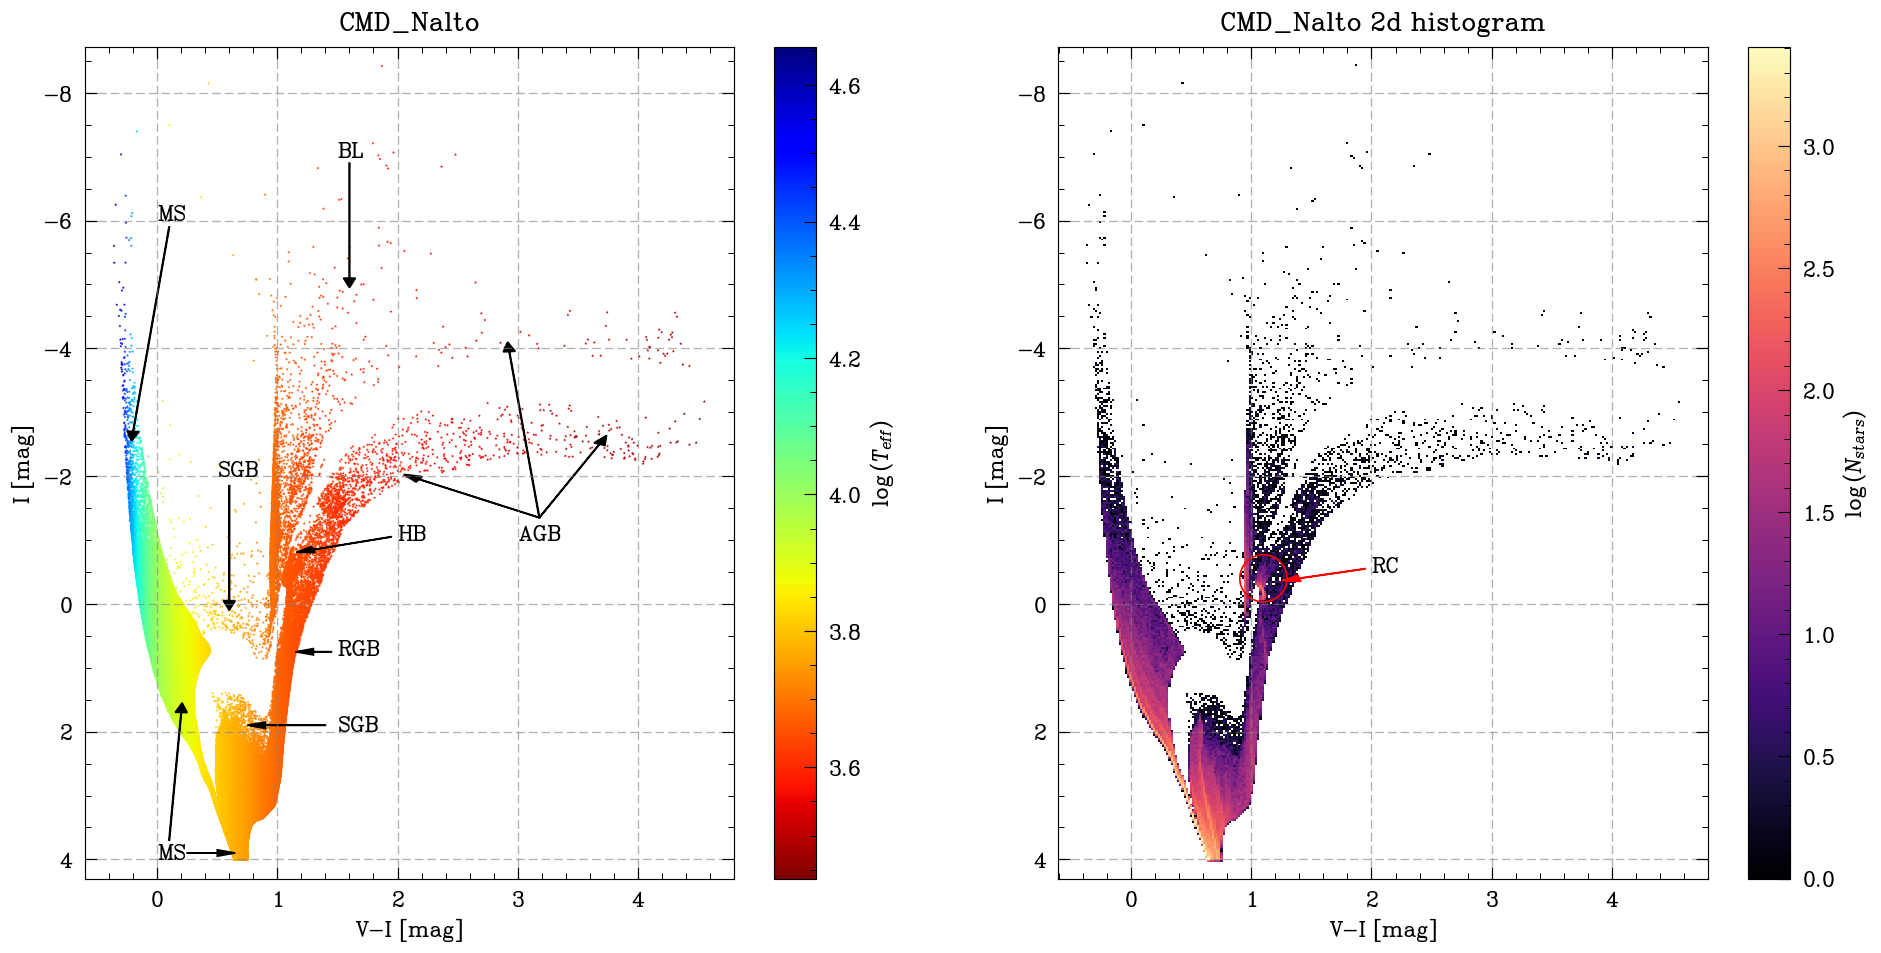

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.8*4,3*3))

cmap=plt.cm.magma
cmap.set_bad(color = 'w', alpha = 1.)

ax[0].set_title('CMD_Nalto')
ax[0].set_xlabel('V-I [mag]')
ax[0].set_ylabel(r'I [mag]')
ax[0].set_ylim(np.max(I_Nalto)+0.3, np.min(I_Nalto)-0.3)
sc = ax[0].scatter(VminusI_Nalto, I_Nalto, c=Teff_Nalto, edgecolor='none', s=4, marker='*',cmap=plt.cm.jet.reversed())
cbar = plt.colorbar(sc, orientation='vertical', location='right')
cbar.set_label(r'$\log{(T_{eff})}$')



ax[0].text(0,-6,'MS')
ax[0].arrow(0+0.1,-6+0.1,-0.3,+3.2,width=0.005,head_width=0.1)

ax[0].text(-0,4,'MS')
ax[0].arrow(0+0.1,4-0.3,0.1,-2,width=0.005,head_width=0.1)
ax[0].arrow(0+0.1+0.15,4-0.1,0.25,0.0,width=0.005,head_width=0.1)

ax[0].text(0.5,-2,'SGB')
ax[0].arrow(0.5+0.1,-2+0.15,0,+1.8,width=0.005,head_width=0.1)

ax[0].text(1.5,2,'SGB')
ax[0].arrow(1.5-0.1,2-0.1,-0.5,0,width=0.005,head_width=0.1)


ax[0].text(1.5,-7,'BL')
ax[0].arrow(1.5+0.1,-7+0.1,0,1.8,width=0.005,head_width=0.1)

ax[0].text(1.5,0.8,'RGB')
ax[0].arrow(1.5-0.05,0.8-0.05,-0.15,0,width=0.005,head_width=0.1)


ax[0].text(3,-1,'AGB')
ax[0].arrow(3+0.18,-1-0.35,0.5,-2*0.7+0.25,width=0.005,head_width=0.1)
ax[0].arrow(3+0.18,-1-0.35,-2*0.5,-2*0.3,width=0.005,head_width=0.1)
ax[0].arrow(3+0.18,-1-0.35,-0.25,-4*0.65,width=0.005,head_width=0.1)


ax[0].text(2,-1,'HB')
ax[0].arrow(2-0.05,-1-0.05,-0.65,+0.2,width=0.005,head_width=0.1)


hist, x_edges, y_edges, bin_number = binned_statistic_2d(VminusI_Nalto, I_Nalto, 1, 
                                                         statistic='count', range=[ax[0].get_xlim(),ax[0].get_ylim()[::-1]],
                                                         bins=[300, 430])

ax[1].set_title('CMD_Nalto 2d histogram')
ax[1].set_xlabel('V-I [mag]')
ax[1].set_ylabel(r'I [mag]')
ax[1].set_ylim(np.max(I_Nalto)+0.3, np.min(I_Nalto)-0.3)

dn = ax[1].imshow(np.log10(hist[:,::-1].T),origin='lower',
           extent=[x_edges[0], x_edges[-1], y_edges[-1], y_edges[0]],
           aspect='auto', interpolation='nearest', cmap=cmap)

cbar = plt.colorbar(dn, orientation='vertical', location='right')
cbar.set_label(r'$\log{(N_{stars})}$')


ax[1].text(2,-0.5,'RC')
ax[1].arrow(2-0.05,-0.5-0.05,-0.55,+0.15,width=0.005,head_width=0.1,color='red')
ax[1].scatter(1.1,0.1-0.5,s=800, color='none', edgecolor='red')



ax[0].grid(True)
ax[1].grid(True)

#plt.savefig('./figures/fig_anotada.png')
plt.show()

Defining the boundaries of each SFR epoch is easy in this case: we donwload a bunch of isocrones from IAC-Star and see (visually) which enclose the SFs better. It is very simple in this case because we have two clear distinct epochs. On real and dirtier CMDs one would have a much harder time doing this (probably the hardes time) because IAC-Star is not remotely queryable and you would need to download a LOT of isocrhones.

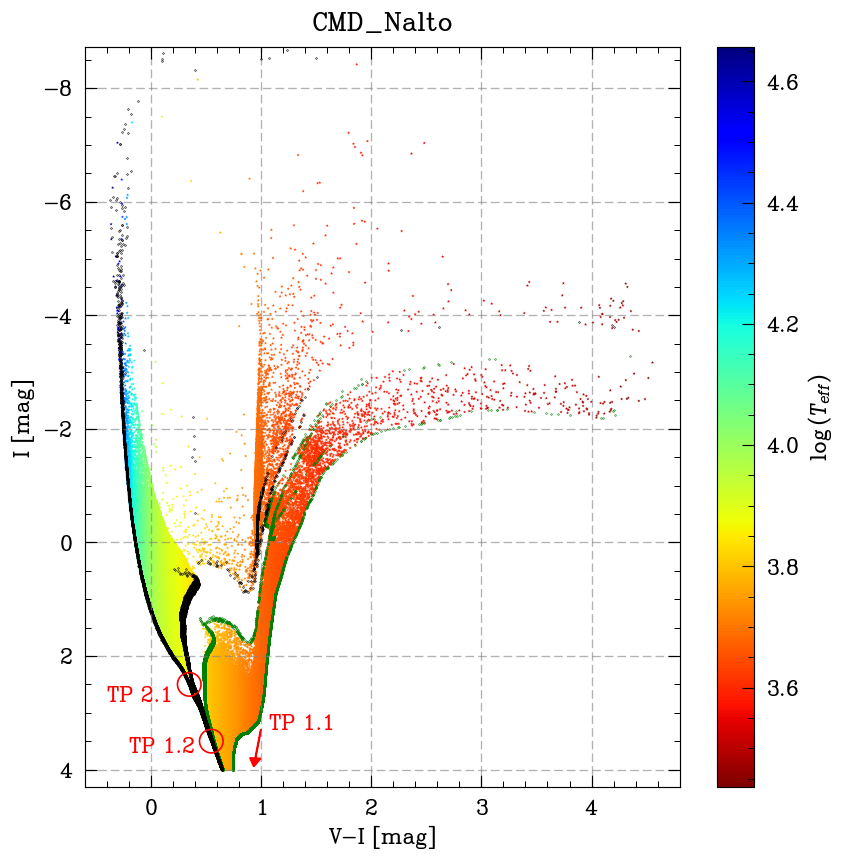

In [55]:
fig, ax = plt.subplots(figsize=(2*4,2*4))

ax.set_title('CMD_Nalto')
ax.set_xlabel('V-I [mag]')
ax.set_ylabel(r'I [mag]')
ax.set_xlim(-0.6,4.8)
ax.set_ylim(np.max(I_Nalto)+0.3, np.min(I_Nalto)-0.3)
sc = ax.scatter(VminusI_Nalto, I_Nalto, c=Teff_Nalto, edgecolor='none', s=4, marker='*',cmap=plt.cm.jet.reversed())
cbar = plt.colorbar(sc, orientation='vertical', location='right')
cbar.set_label(r'$\log{(T_{eff})}$')



df = LoadData('./TP1.1/cmd_16019_0.2')
ax.scatter(df['V']-df['I'], df['I'], color='green', s=0.1, marker='o')

df = LoadData('./TP1.2/cmd_17162_11.0')
ax.scatter(df['V']-df['I'], df['I'], color='green', s=0.1, marker='o')



df = LoadData('./TP2.1/cmd_16905_12.0')
ax.scatter(df['V']-df['I'], df['I'], color='black', s=0.1, marker='o')

df = LoadData('./TP2.2/cmd_19923_12.99')
ax.scatter(df['V']-df['I'], df['I'], color='black', s=0.1, marker='o')





ax.scatter(0.55,3.5,s=200,color='none',edgecolor='red')
ax.text(-0.2,3.7,'TP 1.2',color='red')

ax.arrow(1.07-0.07,3.3,-0.05,0.5,width=0.005,head_width=0.1, color='red')
ax.text(1.07,3.3,'TP 1.1',color='red')

ax.scatter(0.35,2.5,s=200,color='none',edgecolor='red')
ax.text(-0.4,2.8,'TP 2.1',color='red')

ax.grid(True)

#plt.savefig('./figures/fig_brotes.png')
plt.show()

Now that we have defined the outbreaks of star formation, I proceed to define the different regions I want to take into account for the fitting. The fitting will be done to constain the relative star formation rates. This is because two reasons: 1) you cannot specify absolute SFRs on IAC-Star, and 2) this way we can reduce the number of parameters to be fitted from two to one.

You can see that the regions are defined a bit oddly... this is because i will be plotting them later. The key point is to recognize the following structure:

box = [[xmin,...,xmax],
       [ymin,...,ymax]]

Rember, boxes can only be defined to be squares/rectangles.

At last, I will define a array of boxes. This is because the function that computes the $\chi^2$ needs to know how many and where are the boxes, to iterate over them.

In [56]:
box_AGB = np.array([[1.8,1.8,4.6,4.6,1.8],
                    [-1.5,-3.3,-3.3,-1.5,-1.5]])
box_RGB = np.array([[0.9,0.9,1.3,1.3,0.9],
                    [2.5,0,0,2.5,2.5]])
box_HB_RC = np.array([[0.9,0.9,1.8,1.8,0.9],
                      [0,-1.8,-1.8,0,0]])
box_MS2 = np.array([[-0.4,-0.4,0.3,0.3,-0.4],
                    [2.5,-4,-4,2.5,2.5]])
box_MS1 = np.array([[0.3,0.3,0.9,0.9,0.3],
                    [4,1.2,1.2,4,4]])
boxes = np.array([box_MS1,box_MS2,box_RGB,box_HB_RC,box_AGB])


Take a quick look at the boxes. Alongside each box, the Freedman-Diaconis rule-determinated binsize for optimum mesh is displayed. This rule determines the bin number (homogeneous spacing) by looking at the size of the region, the number of points AND the distribution of these, quantified by the interquartile range or iqr.

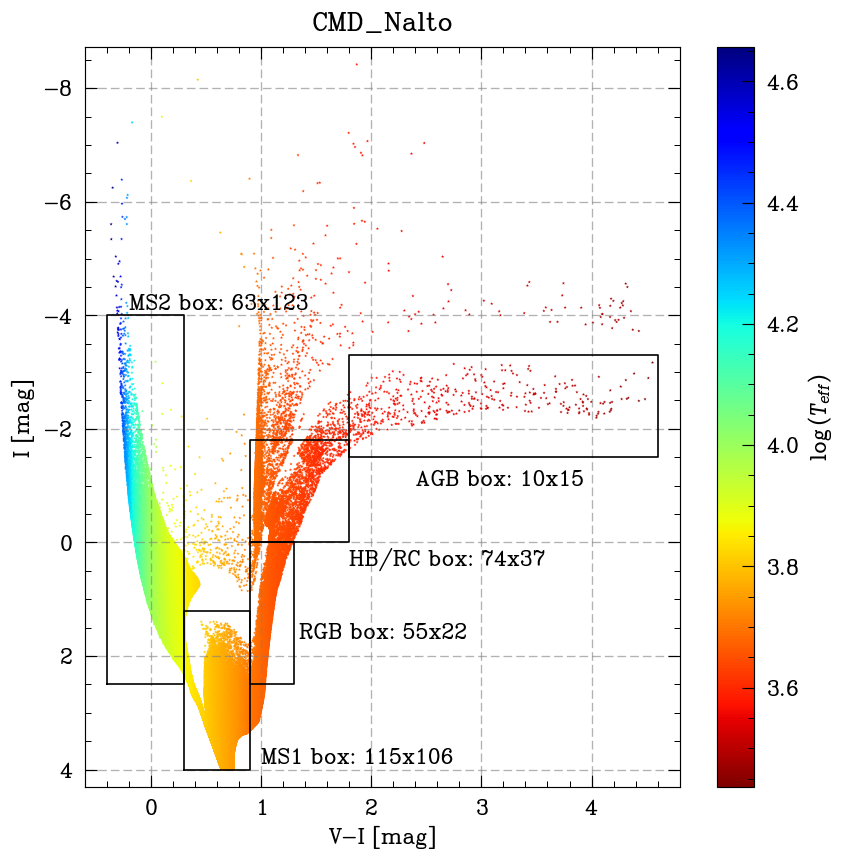

In [57]:
fig, ax = plt.subplots(figsize=(2*4,2*4))

ax.set_title('CMD_Nalto')
ax.set_xlabel('V-I [mag]')
ax.set_ylabel(r'I [mag]')
ax.set_xlim(-0.6,4.8)
ax.set_ylim(np.max(I_Nalto)+0.3, np.min(I_Nalto)-0.3)
sc = ax.scatter(VminusI_Nalto, I_Nalto, c=Teff_Nalto, edgecolor='none', s=4, marker='*',cmap=plt.cm.jet.reversed())
cbar = plt.colorbar(sc, orientation='vertical', location='right')
cbar.set_label(r'$\log{(T_{eff})}$')

a = 'V-I'
b = 'I'
bundle = BundleMaker(box_AGB, mock_CMD_Nalto)
ax.plot(box_AGB[0,:],box_AGB[1,:],color='black', lw=1)
ax.text(2.4,-1,f'AGB box: {getBinNumber(bundle[a])}x{getBinNumber(bundle[b])}')

bundle = BundleMaker(box_RGB, mock_CMD_Nalto)
ax.plot(box_RGB[0,:],box_RGB[1,:], color='black', lw=1)
ax.text(1.35,1.7,f'RGB box: {getBinNumber(bundle[a])}x{getBinNumber(bundle[b])}')

bundle = BundleMaker(box_HB_RC, mock_CMD_Nalto)
ax.plot(box_HB_RC[0,:],box_HB_RC[1,:], color='black', lw=1)
ax.text(1.8,0.4,f'HB/RC box: {getBinNumber(bundle[a])}x{getBinNumber(bundle[b])}')

bundle = BundleMaker(box_MS2, mock_CMD_Nalto)
ax.plot(box_MS2[0,:],box_MS2[1,:], color='black', lw=1)
ax.text(-0.2,-4.1,f'MS2 box: {getBinNumber(bundle[a])}x{getBinNumber(bundle[b])}')

bundle = BundleMaker(box_MS1, mock_CMD_Nalto)
ax.plot(box_MS1[0,:],box_MS1[1,:], color='black', lw=1)
ax.text(1,3.9,f'MS1 box: {getBinNumber(bundle[a])}x{getBinNumber(bundle[b])}')


ax.grid(True)

#plt.savefig('./figures/fig_bundles.png')
plt.show()

Take a loot to see if the meshes are done correctly:

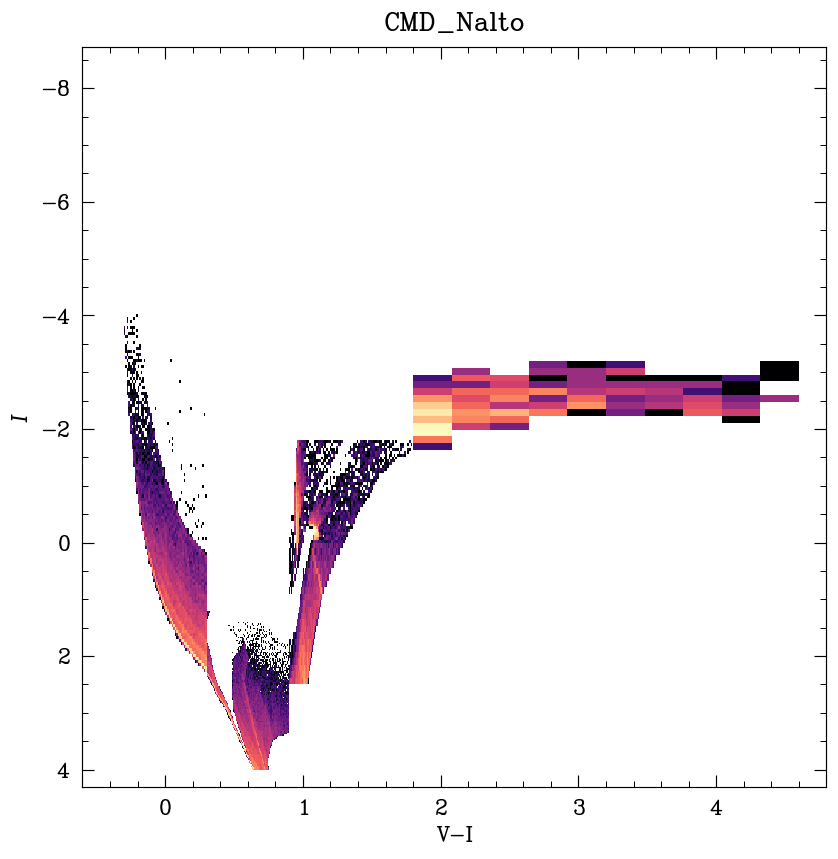

In [59]:
fig, ax = plt.subplots(figsize=(2*4,2*4))
ax.set_title('CMD_Nalto')
ax.set_xlabel('V-I')
ax.set_ylabel(r'$I$')
ax.set_xlim(-0.6,4.8)
ax.set_ylim(np.max(I_Nalto)+0.3, np.min(I_Nalto)-0.3)

for box in boxes:
    bundle = BundleMaker(box, mock_CMD_Nalto)
    binx, biny = getBinNumber(bundle['V-I']), getBinNumber(bundle['I'])
    hist_bundle, x_edges_bundle, y_edges_bundle, bin_number_bundle = binned_statistic_2d(bundle['V-I'], bundle['I'], 1, 
                                                                                         statistic='count', range=[[box[0,:].min(),box[0,:].max()],[box[1,:].min(),box[1,:].max()]],
                                                                                         bins=(binx, biny))
    ax.imshow(np.log10(hist_bundle[:,::-1].T),origin='lower',
           extent=[x_edges_bundle[0], x_edges_bundle[-1], y_edges_bundle[-1], y_edges_bundle[0]],
           aspect='auto', interpolation='nearest', cmap=cmap)

#ax.scatter(VminusI_Nalto[::1], I_Nalto[::1], c='red', edgecolor='none', s=1, marker='o', alpha=0.2)

plt.show()


Now, lets get dirty: lets start computing $\chi^2$s. The idea is to pre-download a bunch of CMDs from IAC-Star with the SFR epochs determined befor, but with different SFR intensities. Iterating over them we can get a $\chi^2$ value for each of them, and then make a rel_SFR vs $\chi^2$ plot to see where the minimun lies. Notice that you can select if you want to do the meshes or not, and if you want the function to display intermediate information while running or not.

At the end we are left with two arrays: fit quality as rel_SFR. 

In [8]:
files = os.listdir('./cmd_comparison/')
files = np.sort(files)[1:]
a='_'

relative_SFR = np.zeros((len(files)))
chi_squared = np.zeros_like(relative_SFR)
chi_squared_easy = np.zeros_like(relative_SFR)


for i, file in enumerate(files):
    print(f'{file}:')
    iac_CMD = LoadData('./cmd_comparison/'+file)
    iac_CMD['V-I'] = iac_CMD['V']-iac_CMD['I']
    chi_sq = caluclate_chi_squared(mock_CMD_Nalto, iac_CMD, boxes,'V-I','I',do_mesh=True, verbose=False)
    chi_sq2 = caluclate_chi_squared(mock_CMD_Nalto, iac_CMD, boxes,'V-I','I',do_mesh=False, verbose=False)
    relative_SFR[i], chi_squared[i], chi_squared_easy[i] = file.split(a)[0], chi_sq, chi_sq2
    print(f'Relative SFR: {relative_SFR[i]}, chi_squared: {chi_squared[i]:.3f} | {chi_sq2:.3f}\n')


0.2_cmd_13586:
Relative SFR: 0.2, chi_squared: 8.573 | 20132.726

0.5_cmd_15413:
Relative SFR: 0.5, chi_squared: 7.046 | 16057.554

2.0_cmd_23304:
Relative SFR: 2.0, chi_squared: 2.468 | 3960.559

3.0_cmd_22085:
Relative SFR: 3.0, chi_squared: 1.224 | 813.342

3.5_cmd_6310:
Relative SFR: 3.5, chi_squared: 0.952 | 160.315

4.0_cmd_23482:
Relative SFR: 4.0, chi_squared: 0.911 | 11.472

4.5_cmd_5525:
Relative SFR: 4.5, chi_squared: 1.008 | 220.747

5.0_cmd_24469:
Relative SFR: 5.0, chi_squared: 1.211 | 806.614

6.0_cmd_31813:
Relative SFR: 6.0, chi_squared: 1.903 | 2648.779

7.0_cmd_28758:
Relative SFR: 7.0, chi_squared: 2.876 | 5198.785

8.0_cmd_30988:
Relative SFR: 8.0, chi_squared: 4.035 | 8207.935



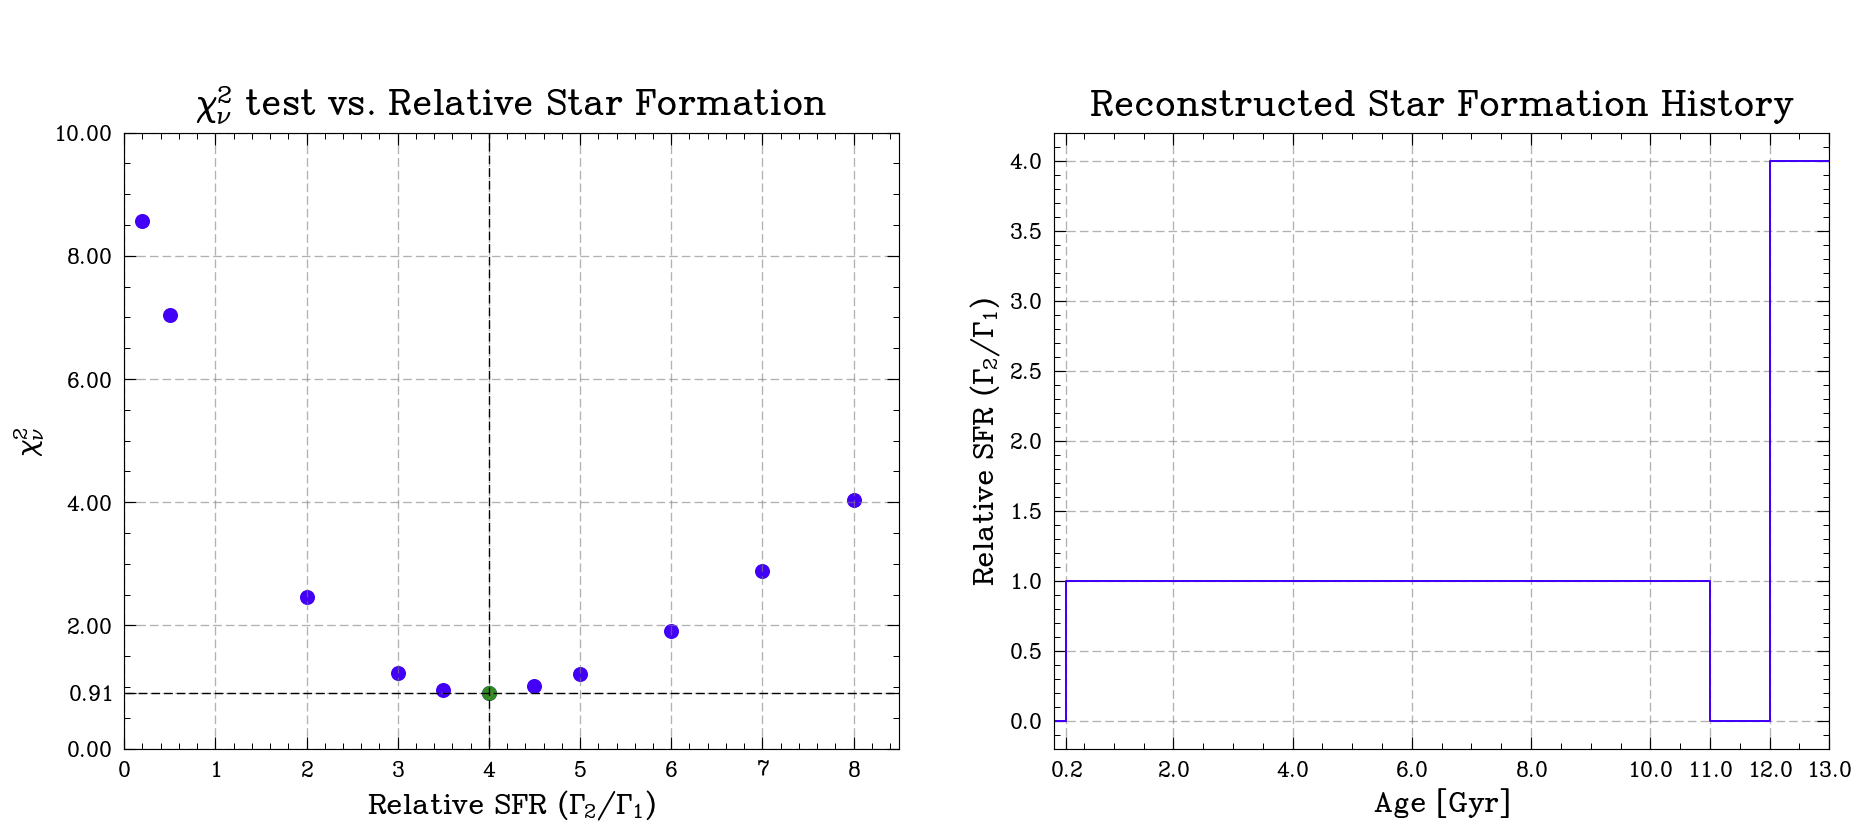

In [15]:
fig, (ax, ax2) = plt.subplots(figsize=(2*11/1.2,8/1.2), ncols = 2)

ax.set_title(r'$\chi^2_\nu$ test vs. Relative Star Formation',fontsize=25)
ax.set_xlabel(r'Relative SFR ($\Gamma_2/\Gamma_1$)',fontsize=20)
ax.set_ylabel(r'$\chi^2_\nu$',fontsize=20)
ax.set_xlim(0,8.5)
ax.set_ylim(0,10)
ax.set_yticks([round(chi_squared.min(),2),0,2,4,6,8,10])
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
#ax.set_xticks([relative_SFR[np.argmin(chi_squared)],0,2,4,6,8,10])

ax.hlines(chi_squared.min(),-10,10,color='k', ls='--', lw=0.8)
ax.vlines(relative_SFR[np.argmin(chi_squared)],-10,1000,color='k', ls='--', lw=0.8)
ax.scatter(relative_SFR, chi_squared,color='C2')
ax.scatter(relative_SFR[np.argmin(chi_squared)],chi_squared.min(),color='C3')

ax.grid(True)



ax2.set_title('\n\nReconstructed Star Formation History',fontsize=25)

ax2.plot([0, 0.2, 0.2, 11, 11, 12, 12, 13],[0, 0, 1, 1, 0, 0, 4, 4],color='C2')

ax2.grid(True)
ax2.set_xticks([0.2,11,12,13,2,4,6,8,10],minor=False)
ax2.set_xticks(np.arange(0,13,0.5),minor=True)
ax2.set_xlim(0,13)
ax2.set_xlabel('Age [Gyr]',fontsize=20)
ax2.set_ylabel(r'Relative SFR ($\Gamma_2/\Gamma_1$)',fontsize=20)
#plt.savefig('./figures/chi_SFR_vertical.png')
plt.show()

So we have now determined a best CMD!! and reconstructed the SFR of the original CMD. Now, take into account that A LOT MORE goes into this than i have just described. Particularly, one needs to select a lot of parameters to generate the IAC-Star CMDs, say IMFs, magnitude corrections, and metalicity laws. Each will depend on you choice, this is the nice part of this: you customize it to obtain the best result possible, instead of having an automatic program that does a bunch of things that you cannot control. The metalicity law is particularly important because of the age-metalicity degeneracy.

Lets see how the fitted CMD looks:

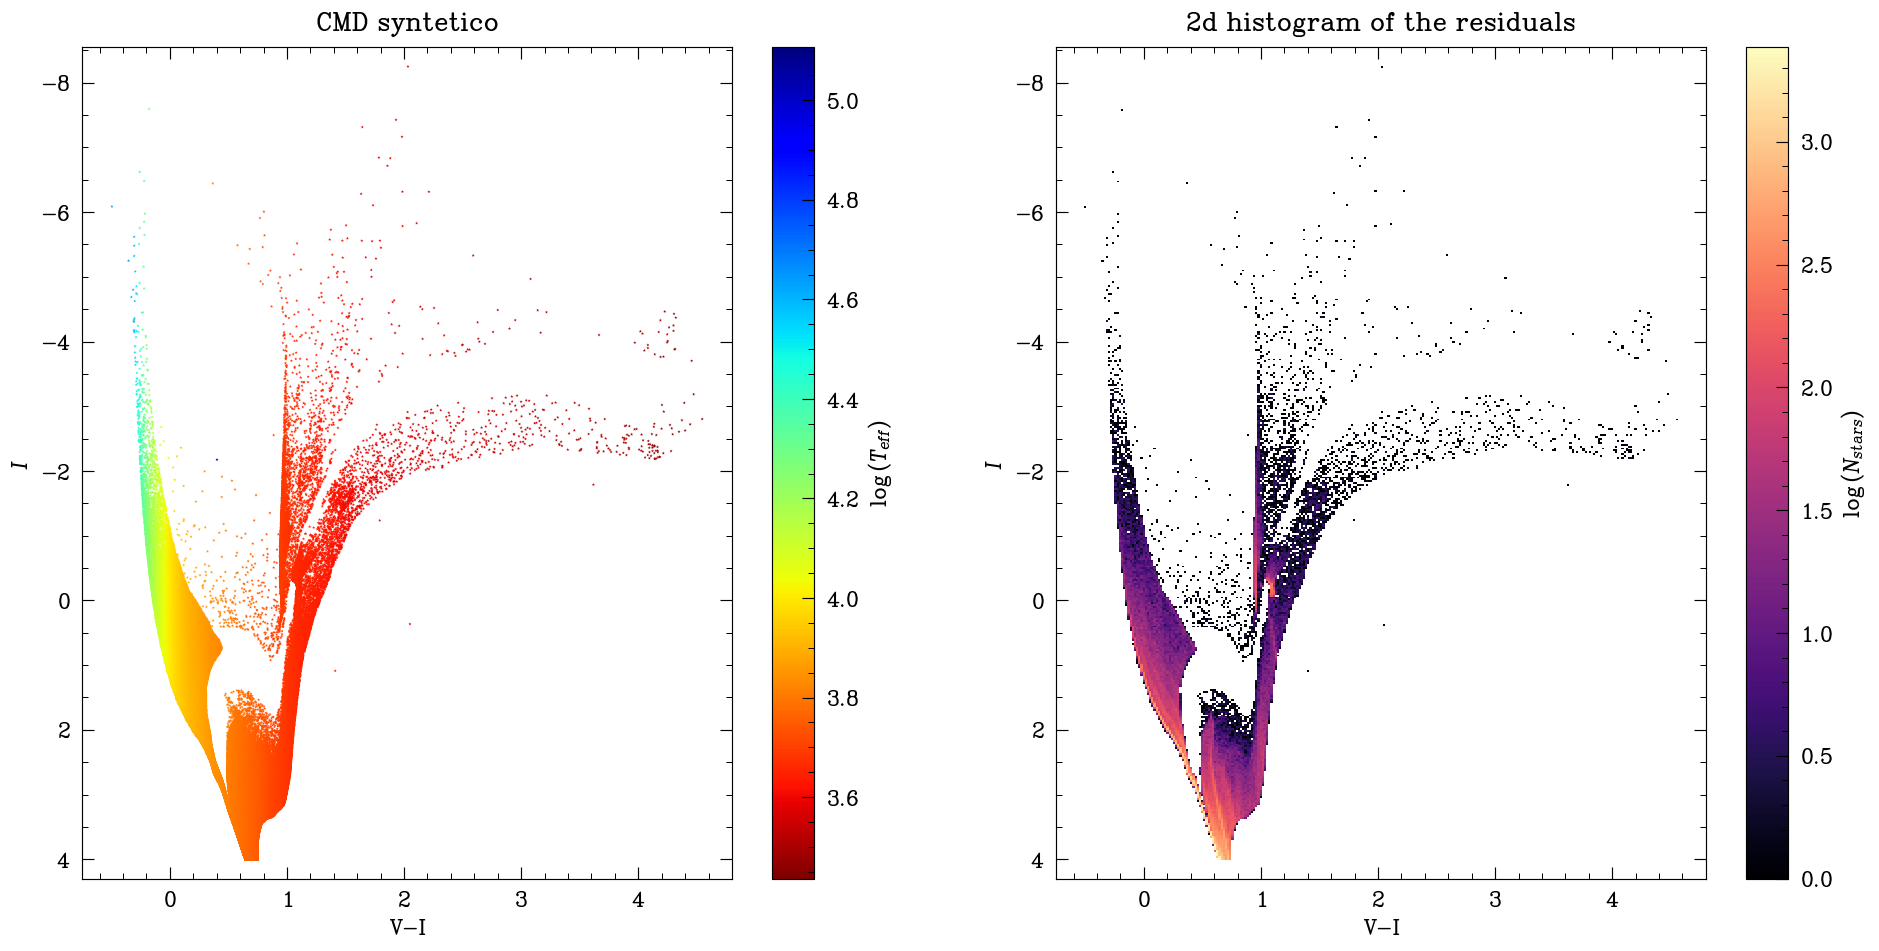

In [10]:
cmd_synthetic = LoadData('./cmd_comparison/4.0_cmd_23482')

cmd_synthetic['V-I'] = cmd_synthetic['V']-cmd_synthetic['I']

VminusI = cmd_synthetic['V-I']
I = cmd_synthetic['I']
Teff = cmd_synthetic['log(Teff)']


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4.8*4,3*3))

cmap=plt.cm.magma
cmap.set_bad(color = 'w', alpha = 1.)

ax[0].set_title('CMD syntetico')
ax[0].set_xlabel('V-I')
ax[0].set_ylabel(r'$I$')
ax[0].set_ylim(np.max(I)+0.3, np.min(I)-0.3)
sc = ax[0].scatter(VminusI, I, c=Teff, edgecolor='none', s=4, marker='*',cmap=plt.cm.jet.reversed())
cbar = plt.colorbar(sc, orientation='vertical', location='right')
cbar.set_label(r'$\log{(T_{eff})}$')


hist_synthetic, x_edges_synthetic, y_edges_synthetic, bin_number_synthetic = binned_statistic_2d(VminusI, I, 1,
                                                                                                 statistic='count', range=[ax[0].get_xlim(),ax[0].get_ylim()[::-1]],
                                                                                                 bins=[300, 430])

ax[1].set_title('2d histogram of the residuals')
ax[1].set_xlabel('V-I')
ax[1].set_ylabel(r'$I$')
ax[1].set_ylim(np.max(I)+0.3, np.min(I)-0.3)

dn = ax[1].imshow(np.log10(hist_synthetic[:,::-1].T),origin='lower',
           extent=[x_edges_synthetic[0], x_edges_synthetic[-1], y_edges_synthetic[-1], y_edges_synthetic[0]],
           aspect='auto', interpolation='nearest', cmap=cmap)

cbar = plt.colorbar(dn, orientation='vertical', location='right')
cbar.set_label(r'$\log{(N_{stars})}$')



#plt.savefig('./figures/synthetic.png')

And now lets see the residuals of the fit:

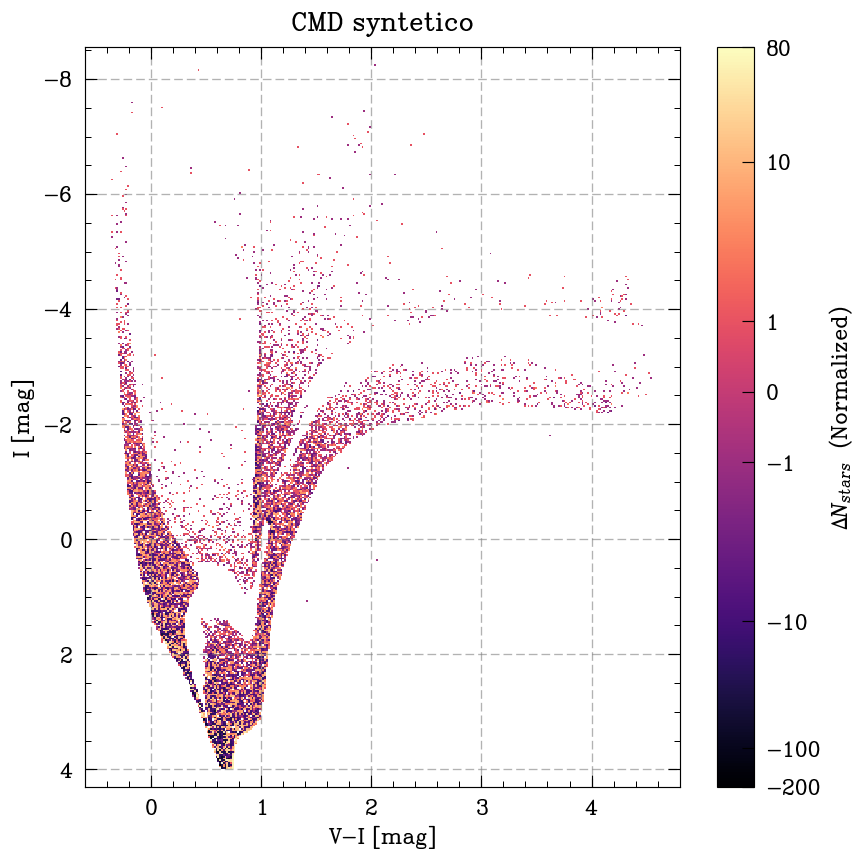

In [40]:
synthetic_cmd_mask = (VminusI<=VminusI_max) & (VminusI>=VminusI_min) & (I<=I_max) & (I>=I_min)
mock_cmd_mask = (VminusI_Nalto<=VminusI_max) & (VminusI_Nalto>=VminusI_min) & (I_Nalto<=I_max) & (I_Nalto>=I_min)

hist, x_edges, y_edges, bin_number = binned_statistic_2d(VminusI_Nalto[mock_cmd_mask], I_Nalto[mock_cmd_mask], 1, 
                                                         statistic='count', range=[[VminusI_min,VminusI_max],[I_min,I_max]], bins=[300, 430])
hist_synthetic, x_edges_synthetic, y_edges_synthetic, bin_number_synthetic = binned_statistic_2d(VminusI[synthetic_cmd_mask], I[synthetic_cmd_mask], 1, 
                                                                                                 statistic='count', range=[[VminusI_min,VminusI_max],[I_min,I_max]],
                                                                                                 bins=[300, 430])

residuals = hist-hist_synthetic

cmin, cmax = round(residuals.min(),-1),round(residuals.max(),-1)

mask_zero = (residuals == 0)
residuals[mask_zero] = -np.inf

fig, ax = plt.subplots(figsize=(2*4,2*4))

cmap=plt.cm.magma
cmap.set_bad(color = 'w', alpha = 1.)

ax.set_title('CMD syntetico')
ax.set_xlabel('V-I [mag]')
ax.set_ylabel(r'I [mag]')
ax.set_ylim(np.max(I)+0.3, np.min(I)-0.3)
ax.set_xlim(-0.6,4.8)

dn = ax.imshow((residuals[:,::-1].T)*np.minimum(len(cmd_synthetic)/len(mock_CMD_Nalto),len(mock_CMD_Nalto)/len(cmd_synthetic)),
           origin='lower',
           extent=[x_edges_synthetic[0], x_edges_synthetic[-1], y_edges_synthetic[-1], y_edges_synthetic[0]],
           aspect='auto', interpolation='nearest', cmap=cmap, norm='symlog')

cbar = plt.colorbar(dn, orientation='vertical', location='right')
cbar.set_label(r'$\Delta N_{stars} \ $ (Normalized)')
dn.set_clim(cmin, cmax)
a = [-200,-100,-10,-1,0,1,10,80]
cbar.set_ticks(a)
cbar.set_ticklabels([str(e) for e in a])


ax.grid(True)
#plt.savefig('./figures/residuals.png')
plt.show()

They certainly look very nice, of the order of 1% of the average stars in te bins.

Lastly, wee can compute a bunch of quantities of the original CMD, using the fitted CMD, given that IAC-Star generates a lot of columns.

In [13]:
Mtot = np.sum(cmd_synthetic["massin"][cmd_synthetic['massin']>0])*np.minimum(len(cmd_synthetic)/len(mock_CMD_Nalto),len(mock_CMD_Nalto)/len(cmd_synthetic))
Ltot = np.sum(10**cmd_synthetic["log(L)"][cmd_synthetic['massin']>0])*np.minimum(len(cmd_synthetic)/len(mock_CMD_Nalto),len(mock_CMD_Nalto)/len(cmd_synthetic))
print(f'Total mass of the cmd is {Mtot:.2e} Msun')
print(f'Total luminosity of the cmd is {Ltot:.2e} Lsun\n')

l, m = 0, 0
for i, box in enumerate(boxes):
    bundle_synth = BundleMaker(box,cmd_synthetic)
    bundle_mock = BundleMaker(box, mock_CMD_Nalto)
    Mbundle = np.sum(bundle_synth['massin'][cmd_synthetic['massin']>0])*np.minimum(len(bundle_mock)/len(bundle_synth),len(bundle_synth)/len(bundle_mock))
    Lbundle = np.sum(10**bundle_synth['log(L)'][cmd_synthetic['massin']>0])*np.minimum(len(bundle_mock)/len(bundle_synth),len(bundle_synth)/len(bundle_mock))
    print(f'----------------------------------------------')
    print(f'Mass of the {i}-th bundle is {Mbundle:.2e} Msun')
    print(f'Luminosity of the {i}-th bundle is {Lbundle:.2e} Lsun')
    print(f'----------------------------------------------\n')
    l = l + Lbundle
    m = m + Mbundle

print(f'Total luminosity and mass of the bundles is {l:.2e} Lsun, {m:.2e} Msun')

Total mass of the cmd is 5.25e+05 Msun
Total luminosity of the cmd is 2.12e+07 Lsun

----------------------------------------------
Mass of the 0-th bundle is 2.89e+05 Msun
Luminosity of the 0-th bundle is 6.94e+05 Lsun
----------------------------------------------

----------------------------------------------
Mass of the 1-th bundle is 1.75e+05 Msun
Luminosity of the 1-th bundle is 8.95e+06 Lsun
----------------------------------------------

----------------------------------------------
Mass of the 2-th bundle is 1.62e+04 Msun
Luminosity of the 2-th bundle is 1.93e+05 Lsun
----------------------------------------------

----------------------------------------------
Mass of the 3-th bundle is 2.72e+04 Msun
Luminosity of the 3-th bundle is 1.17e+06 Lsun
----------------------------------------------

----------------------------------------------
Mass of the 4-th bundle is 5.42e+02 Msun
Luminosity of the 4-th bundle is 4.80e+05 Lsun
----------------------------------------------

